### Import Libraries 

In [74]:
# Pyton 2 and 3 support
from __future__ import division, print_function, unicode_literals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn

%matplotlib inline

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [75]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
#from vis_utils import *
import random;
import math;

### Data Loading

In [78]:
# Declare the essential hyperparameters
num_epochs = 5;
batch_size = 100;
learning_rate = 0.001;

In [79]:
test_df = pd.read_csv('data/MNIST/raw/fashion-mnist_test.csv')
test_labels_df = test_df['label']
test_pixels_df = test_df.drop('label', axis=1)

# This reads the csv file into a pandas dataframe
train_df = pd.read_csv('data/MNIST/raw/fashion-mnist_train.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
train_pixels_df = train_df.drop('label', axis=1)
train_pixels_df.head()
train_labels_df = train_df['label']
train_labels_df.values

array([2, 9, 6, ..., 8, 8, 7])

* load the images BEFORE training so that you don't have to iterate/parse through files 
* create array for images
* create array for label
* iterate through each line and assign a label to images (index to each together) 
* download the clothing category txt file and additionally go to "eval" folder and download that file that separates data into test, training, and validation --> 
* write a function to get the labels
* write a function to convert to pixels 
* make sure it's in form of np.array 
* remember to normalize data using "mean" technique 
* can cheat and use half the data hehehehehe
* running it on paperspace will take 1 hour

In [81]:
# In Pytorch, for data loading I implement a class that inherits the Dataset type and defines
# the data reading functions and data access functions
# process data beforehand and put that data into the dataset so that when you train your model, you are not processing through the data at the same time 
# dataset defines how you access and return the data...for example, you create a dataset class with the certain images in that class
# data loader class (not as important, on the other hand, connects your dataset (acts as the delivery man while dataset class packages the data)
class FashionDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.labels = torch.LongTensor(labels)
        self.df = dataframe
        
    def __getitem__(self, index):
        # I'm using .loc to access the row of the dataframe by index
        # HINT You don't need to do this but try normalizing your image vector before making it a torch Tensor.
        # BONUS train your model with and without normalization and see what happens
        img = torch.Tensor(self.df.loc[index].values)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)
    
    
'''
This class is for providing image data as (1, 28, 28) tensor as opposed to a (784) tensor. You
use these for conv2d layers which are powerful for image recognition!
'''
class Fashion2DDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.labels = torch.LongTensor(labels)
        self.df = dataframe
        
    def __getitem__(self, index):
        # I'm using .loc to access the row of the dataframe by index
        a = self.df.loc[index].values
        a = np.split(a, 28)
        a = np.array([a])
        img = torch.Tensor(a)
        
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

In [82]:
# Make data iterable 
# Define data loaders using DataLoader module: 
train_dataset = Fashion2DDataset(train_pixels_df, train_labels_df.values)
test_dataset = Fashion2DDataset(test_pixels_df, test_labels_df.values)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### The Network

Time to implement the Neural Network graph! One of the reasons why PyTorch is preferred sometimes over TensorFlow and Keras is because it defines graphs easier and makes it more intuitive to understand. However, PyTorch doesn't implement a lot of the necessary functions that are available in TensorFlow, such as those used for transformations. (As a side note, TorchSample can instead be used for data augmentation). 

In [91]:
class Swish(nn.Module):
    def forward(self, input):
        return (input * torch.sigmoid(input))
  
    def __repr__(self):
        return self.__class__.__name__ + ' ()'

In [92]:
class CNNModel(nn.Module):
    def __init__ (self):
        super(CNNModel,self).__init__()
        
        self.cnn1=nn.Conv2d(in_channels=1,out_channels=16, kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(16)
        self.swish1=Swish()
        nn.init.xavier_normal(self.cnn1.weight)
        self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=1)
        
        self.cnn2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(32)
        self.swish2=Swish()
        nn.init.xavier_normal(self.cnn2.weight)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.cnn3=nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(64)
        self.swish3=Swish()
        nn.init.xavier_normal(self.cnn3.weight)
        self.maxpool3=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(64*6*6,10)
        
        self.softmax=nn.Softmax(dim=1)
        
        
    def forward(self,x):
        out=self.cnn1(x)
        out=self.bn1(out)
        out=self.swish1(out)
        out=self.maxpool1(out)
        out=self.cnn2(out)
        out=self.bn2(out)
        out=self.swish2(out)
        out=self.maxpool2(out)
        out=self.cnn3(out)
        out=self.bn3(out)
        out=self.swish3(out)
        out=self.maxpool3(out)
        out=out.view(out.size(0),-1)
        out=self.fc1(out)
        out=self.softmax(out)
        
        return out

In [95]:
model=CNNModel()

if torch.cuda.is_available():
    model.cuda()

criterion=nn.BCELoss()

learning_rate=0.015

optimizer=torch.optim.Adagrad(model.parameters(),lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)# this will decrease the learning rate by factor of 0.1 every 10 epochs

In [83]:
## Neural Networks inherited via nn.Module class & define the graph in the constructor 
## Con
#class CNN(nn.Module):
#    # In the constructor, we define the layers using the provided modules from the nn package. 
#    # A sequence of a layer, normalization, activation and pooling can be defined as a Sequential. 
#    # For instance, a convolution layer is defined as nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride). 
#    # After the two convolution layers and activations, end the network with a Fully Connected layer that outputs to 10 classes.
#    def __init__(self):
#        super(CNN, self).__init__()
#        self.layer1 = nn.Sequential(
#            nn.Conv2d(1, 16, kernel_size=5, padding=2),
#            nn.BatchNorm2d(16),
#            nn.ReLU(),
#            nn.MaxPool2d(2))
#        self.layer2 = nn.Sequential(
#            nn.Conv2d(16, 32, kernel_size=5, padding=2),
#            nn.BatchNorm2d(32),
#            nn.ReLU(),
#            nn.MaxPool2d(2))
#        self.fc = nn.Linear(7*7*32, 10)
        
#    # The forward function is called on the NN for a set of inputs, & it passes that input through the different layers that have been defined. 
#    # In this case, pass x through 1st layer, pass it’s output through 2nd layer, & pass that through final fully connected layer to get output. 
#    # The view function in the code about reshapes the output to match dimensions required for final layer.
#    def forward(self, x):
#        out = self.layer1(x)
#        out = self.layer2(out)
#        out = out.view(out.size(0), -1)
#        out = self.fc(out)
#        return out

### Instantiating the Model Class

In [96]:
model = CNN()

### Instantiating the Loss Class

In [97]:
criterion = nn.CrossEntropyLoss();

### Instantiating the Optimizer Class

In [101]:
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training the Model

In [103]:
iter = 0
losses = []
accuracies = []
for epoch in range(1):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
#         images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 60 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images with gradient accumulation capabilities
#                 images = images.view(-1, 28*28).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            
            accuracies.append(accuracy)
            losses.append(loss.item())
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 60. Loss: 0.44628772139549255. Accuracy: 85
Iteration: 120. Loss: 0.5890499353408813. Accuracy: 83
Iteration: 180. Loss: 0.3337588608264923. Accuracy: 85
Iteration: 240. Loss: 0.4609559178352356. Accuracy: 84
Iteration: 300. Loss: 0.5433986783027649. Accuracy: 81
Iteration: 360. Loss: 0.5241296887397766. Accuracy: 85
Iteration: 420. Loss: 0.48193198442459106. Accuracy: 85
Iteration: 480. Loss: 0.4080311954021454. Accuracy: 85
Iteration: 540. Loss: 0.4110163152217865. Accuracy: 86
Iteration: 600. Loss: 0.47327613830566406. Accuracy: 83


### Evaluating Model on Test Dataset

In [104]:
# Change the mode of the network to eval
# Feed the images through the network to get the outputs
# Get the output label by taking the max from the one-hot outputs
# Count the correct predictions by comparing them to the labels
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 10.0000 %


### Visualizing the Loss

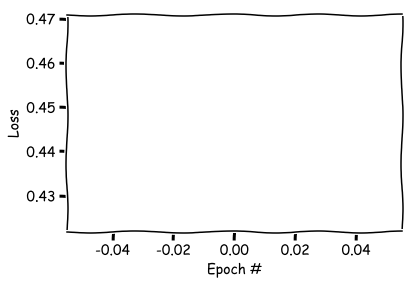

In [105]:
# visualize the loss from the training over the number of epochs
losses_in_epochs = losses[0::600]
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses_in_epochs);
plt.show();

### Visualizing the Filters

<Figure size 432x288 with 0 Axes>

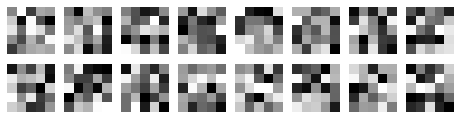

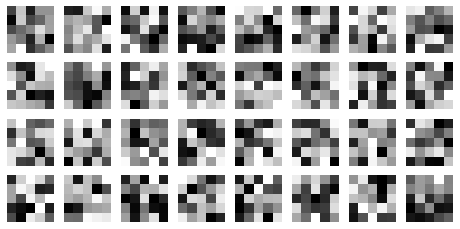

In [106]:
# In a convolutional network, let the network learn the filters that help it classify an image. 
# For instance, network could identify edges by learning a filter that acts as an edge detector. 
# A more complicated one could learn to identify the handles on a bag.
# Let’s visualize the filters from the first layer and the second layer:
def plot_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0,:,:], cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
filters = cnn.modules();
model_layers = [i for i in cnn.children()];
first_layer = model_layers[0];
second_layer = model_layers[1];
first_kernels = first_layer[0].weight.data.numpy()
plot_kernels(first_kernels, 8)
second_kernels = second_layer[0].weight.data.numpy()
plot_kernels(second_kernels, 8)